# Using Ripser to Compute TDA Barcodes
## Authors: Dhananjay Bhaskar, Zachary Neronha
### Last modified: 24 October, 2018
### Description: Topological data analysis on two and three dimensional synthetic data sets

In [1]:
library(TDA)
library(repr)
library(stringr)
library(scatterplot3d)
library(ripserr)

Welcome to ripserr.


### Ripser C++ Binding
**Note:** Change path below to ripser C++ executable

In [22]:
## Parse raw output from Ripser
parseOutput = function( output ){
    
    ## Number of intervals by dimension
    indices            = grep( "persistence intervals in dim " , output , value = FALSE )
    maxDimension       = length( indices ) - 1
    indices            = c( indices , length( output ) )
    
    ## Convert output in matrix
    diagram = matrix(, ncol = 3, nrow = 0 )
    
    ## Loop each group of intervals by dimension
    for( dim in 0:maxDimension ){
        
        ## Select intervals
        if( dim == maxDimension ){
            intervals = output[ ( indices[ dim + 1 ] + 1):( indices[ dim + 2 ] ) ]
        }else{
            intervals = output[ ( indices[ dim + 1 ] + 1):( indices[ dim + 2 ] - 1 ) ]
        }
        
        ## Removed lines from output
        intervals = grep( "\\[\\d*\\.?\\d+\\,\\d*\\.?\\d+\\)" , intervals , value = TRUE )
        
        ## Remove punctuation from intervals
        intervals = gsub( "(\\s|\\[|\\))" , "" , intervals )
        
        ## Split interval and convert to numeric
        intervals = as.numeric( unlist( strsplit( intervals , "," ) ) )
        
        ## Convert ouput in matrix
        intervals = matrix( intervals , ncol = 2 , byrow = T )
        
        ## Add dimension column
        intervals = cbind( rep( dim , nrow( intervals ) ) , intervals )
        
        ## Add intervals to diagram
        diagram = rbind( diagram, intervals )
        
    }
    
    ## Format matrix to diagram format
    colnames( diagram ) = c( "dimension" , "Birth" , "Death" )
    
    return( diagram )    
}

## Calculate rips diagram using Ripser library
ripserDiag = function( X, dimension, threshold, format = "point-cloud" ){
    
    # Ripser likes to read files in, so use a temporary file
    f = tempfile()
    write.table(X, f, col.names = FALSE, row.names = FALSE)
    
    ## Set parameters as text
    dimension = as.character( dimension )
    threshold = as.character( threshold )
    
    ## Run Ripser using system command
    ripserOut = system2("/home/labmember/ripser/ripser", args = c("--dim", dimension, "--threshold", threshold, "--format", format , f), stdout = TRUE, stderr = TRUE)
    
    return( parseOutput( ripserOut ) )
}

### Compute barcode for pts on a circle

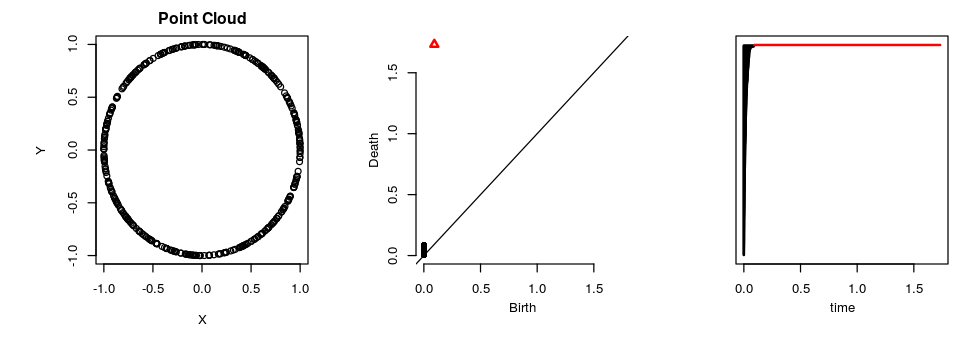

In [5]:
X <- circleUnif(400)
homology_2d_circle <- ripserDiag(X, 1, 5.0)

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=3)

plot(X, xlab="X", ylab="Y", main = "Point Cloud")
TDA::plot.diagram(homology_2d_circle, barcode = FALSE)
TDA::plot.diagram(homology_2d_circle, barcode = TRUE)

### Compute barcode for points in concentric circles
**Observations:** 
- Note two concentric circles with radii $0.8, 2$
- These concentric circles merge when $\epsilon \approx 2-0.8 = 1.2$

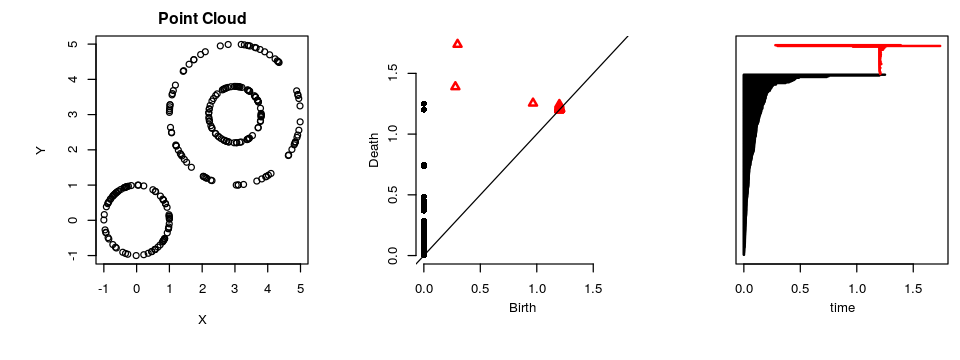

In [6]:
Circle1 = circleUnif(80, r = 1)
Circle2 = circleUnif(80, r = 2) + 3
Circle3 = circleUnif(80, r = 0.8) + 3
Circles = rbind(Circle1, Circle2, Circle3)

homology_2d_conccircles <- ripserDiag(Circles, 1, 10.0)
par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=3)

plot(Circles, xlab="X", ylab="Y", main = "Point Cloud")
TDA::plot.diagram(homology_2d_conccircles, barcode = FALSE)
TDA::plot.diagram(homology_2d_conccircles, barcode = TRUE)

### Compute barcode for clusters that are difficult to identify with kmeans
**Note:** TDA identifies two connected components that die while merging into a single cluster

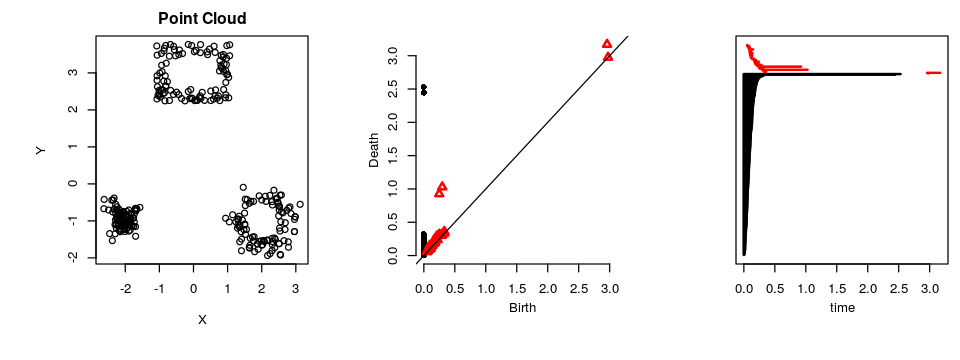

In [7]:
#import and transpose synthetic data
synthetic1 = read.csv(file="PointCloudData/SyntheticData1.csv", head=FALSE)
z = data.matrix(synthetic1)
z = t(z)

#truncate the data to a more manageable size
z = z[seq(1,3000,10),1:2]

homology_2d_syn1 <- ripserDiag(z, 1, 10.0)
par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=3)

plot(z, xlab="X", ylab="Y", main = "Point Cloud")
TDA::plot.diagram(homology_2d_syn1, barcode = FALSE)
TDA::plot.diagram(homology_2d_syn1, barcode = TRUE)

### Compute barcode for clusters that are difficult to identify with kmeans and DBSCAN
**Note:** TDA identifies four connected components that die while merging into a single cluster

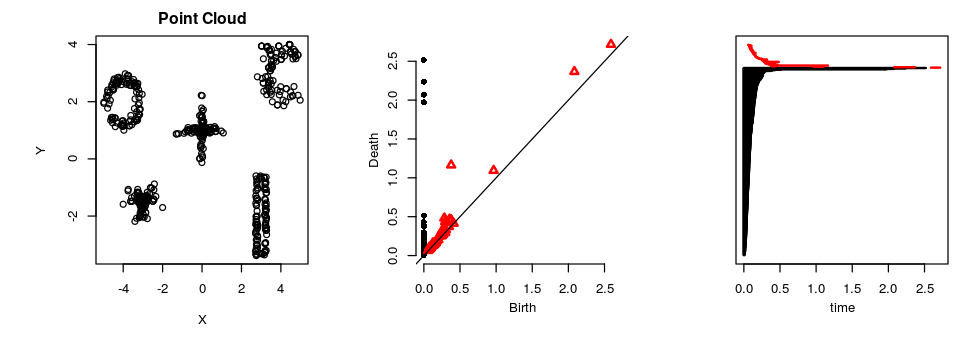

In [8]:
#import and transpose synthetic data
synthetic2 = read.csv(file="PointCloudData/SyntheticData2.csv", head=FALSE)
z = data.matrix(synthetic2)
z = t(z)

homology_2d_syn2 <- ripserDiag(z, 1, 10.0)
par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=3)

plot(z, xlab="X", ylab="Y", main = "Point Cloud")
TDA::plot.diagram(homology_2d_syn2, barcode = FALSE)
TDA::plot.diagram(homology_2d_syn2, barcode = TRUE)

### Compute barcode for points lying on the surface of a 3D sphere
**Note:** Ripser can easily also compute dimension 2 homology

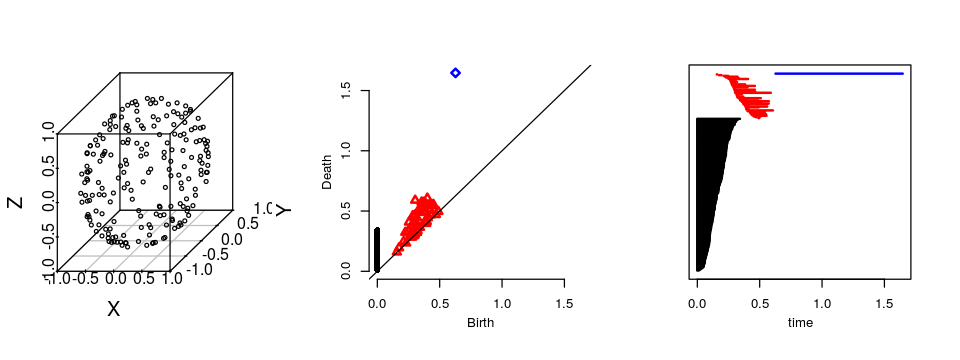

In [9]:
syntheticSph = read.csv(file="PointCloudData/SyntheticDataSph.csv", head=FALSE)
zSph = data.matrix(syntheticSph)

homology2_zSph <- ripserDiag(zSph, 2, 5.0)

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=3)

scatterplot3d(zSph, y=NULL, z=NULL, xlab="X", ylab="Y", zlab="Z")
TDA::plot.diagram(homology2_zSph, barcode = FALSE)
TDA::plot.diagram(homology2_zSph, barcode = TRUE)

### Compute barcode for points on two concentric spheres
**Observations:** 
- Inner sphere with radius $r_1 = 0.2$, outer sphere takes radius $r_2 = 1$
- Two connected components merge at $\epsilon \approx r_2-r_1 = 0.8$

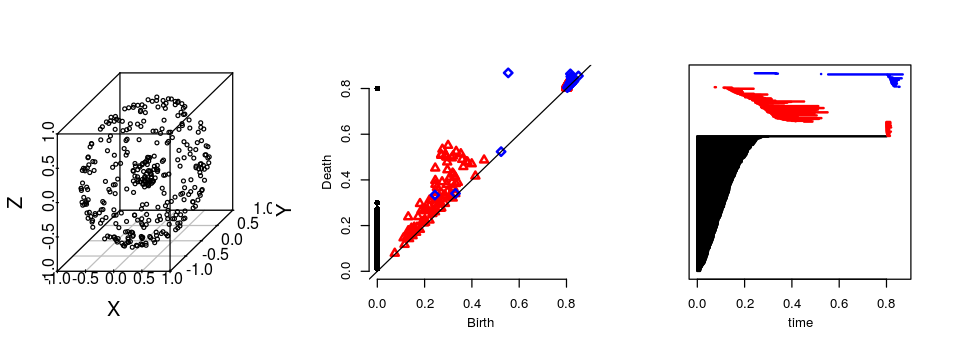

In [10]:
syntheticSph2 = read.csv(file="PointCloudData/SyntheticDataSph2.csv", head=FALSE)
zSph2 = data.matrix(syntheticSph2)

homology2_zSph2 <- ripserDiag(zSph2, 2, 10.0)

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=3)

scatterplot3d(x=zSph2, y=NULL, z=NULL, xlab="X", ylab="Y", zlab="Z")
TDA::plot.diagram(homology2_zSph2, barcode = FALSE)
TDA::plot.diagram(homology2_zSph2, barcode = TRUE)

### Compute barcode for points on three concentric spheres
**Observations:** 
- Inner sphere with radius $r_1 = 0.2$, middle sphere takes radius $r_2 = 1$, outersphere takes radius $r_3 = 3$
- Connected components merge at $\epsilon_1 \approx r_2-r_1 = 0.8$ and  $\epsilon_2 \approx r_3-r_2 = 2$ 

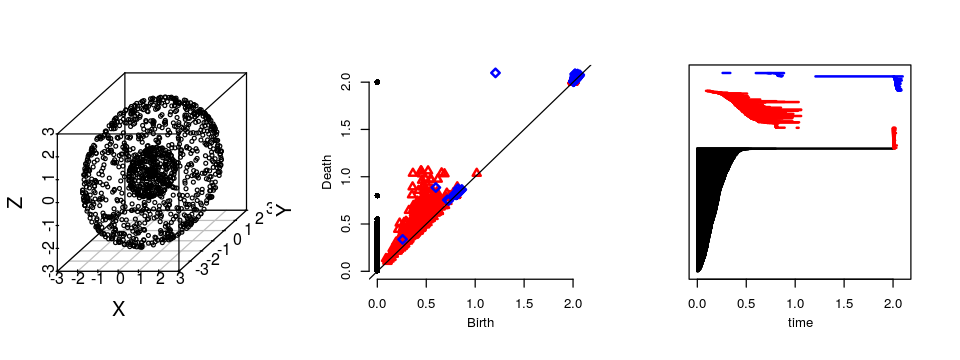

In [27]:
syntheticSPH3 = read.csv(file="PointCloudData/SyntheticDataSph3.csv", head=FALSE)
zSph3 = data.matrix(syntheticSPH3)

homology2_zSph3 <- ripserDiag(zSph3, 2, 3.0)

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=3)

scatterplot3d(x=zSph3, y=NULL, z=NULL, xlab="X", ylab="Y", zlab="Z")
TDA::plot.diagram(homology2_zSph3, barcode = FALSE)
TDA::plot.diagram(homology2_zSph3, barcode = TRUE)

### Compute distances between persistance diagrams

In [30]:
 print(bottleneck(homology2_zSph, homology2_zSph2, dimension = 2))
 print(wasserstein(homology2_zSph, homology2_zSph2, dimension = 2, p = 2))

[1] 0.509713
[1] 0.2881303


### Compute barcode for points on a torus
**Note:** Ripser identifies two topologically distinct loops and one void

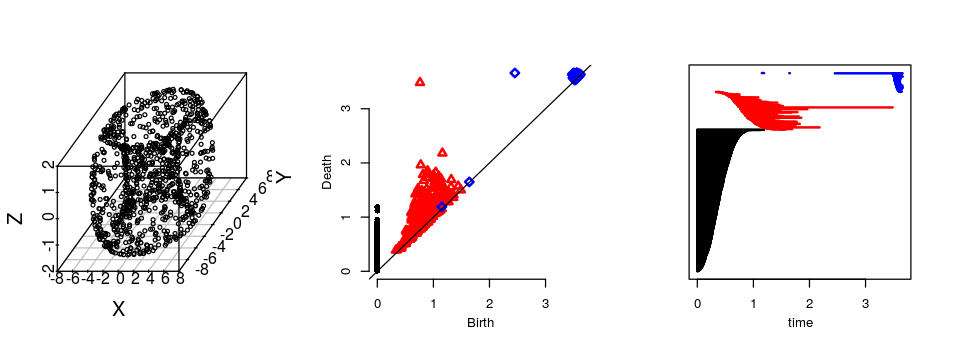

In [32]:
syntheticTorus1 = read.csv(file="PointCloudData/SyntheticDataTorus.csv", head=FALSE)
zTorus1 = data.matrix(syntheticTorus1)

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=3)

homology2_zTorus1 <- ripserDiag(zTorus1, 2, 4.0)

scatterplot3d(zTorus1, y=NULL, z=NULL, xlab="X", ylab="Y", zlab="Z")
TDA::plot.diagram(homology2_zTorus1, barcode = FALSE)
TDA::plot.diagram(homology2_zTorus1, barcode = TRUE)